# Exploração de Modelos de Regressão
### Autor: Alexandre Saback

# Contextualização do Problema
Agora que a base de dados já foi devidamente explorada, é o momento de realizar uma exploração inicial utilizando modelos simples de regressão para tentar explicar o comportamento dos dados. Caso tais modelos não sirvam como solução final, é possível utilizá-los como _baseline_ para fins de comparação com modelos mais robustos.

# Instalação de Pacotes Adicionais

In [1]:
!pip install statstests
!pip install pyarrow

# Começando
O primeiro passo, mais uma vez, se concentra na importação dos pacotes necessários. Os mesmos pacotes utilizados durante a Análise Exploratória e Descritivas dos dados também serão utilizados aqui. Sendo assim, não irei descrever a funcionalidade de cada um, visto que, isso já foi realizado previamente.

In [2]:
import pandas as pd
import statsmodels.api as sm
from statstests.process import stepwise
from statstests.tests import shapiro_francia
from scipy.stats import boxcox
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.special import inv_boxcox

# Carregando os Dados

## Carregando o Objeto StandardScaler
Como os dados foram padronizados previamente utilizando o objeto StandardScaler, é importante carregá-lo novamente para desfazer tal transformação no momento de realizar predições com modelos de regressão.

In [3]:
with open('scaler.pickle', 'rb') as handle:
  scaler = pickle.load(handle)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Carregando o Dataset Pré-processado

In [4]:
dataset = pd.read_parquet("preprocessed_dataset.parquet", engine="pyarrow")

In [5]:
dataset

,FLG_DATA,QT_VENDA_BRUTO,QT_DEVOLUCAO,VL_RECEITA_BRUTA,VL_RECEITA_LIQUIDA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,...,DES_MARCA_MATERIAL_anon_S87,DES_MARCA_MATERIAL_anon_S88,DES_MARCA_MATERIAL_anon_S89,DES_MARCA_MATERIAL_anon_S9,DES_MARCA_MATERIAL_anon_S90,DES_MARCA_MATERIAL_anon_S91,DES_MARCA_MATERIAL_anon_S92,DES_MARCA_MATERIAL_anon_S93,DES_MARCA_MATERIAL_anon_S94,COD_REGIAO_anon_S10
0,1,0.042982,0.295072,-0.077293,-0.075642,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,-0.299433,0.009735,-0.222117,-0.220986,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1.307519,2.049365,0.112996,0.115330,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,-0.302499,-0.434122,-0.229333,-0.228227,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,-0.232717,-0.011401,-0.202194,-0.200991,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173918,1,-0.187459,-0.434122,-0.195461,-0.194234,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
173919,1,-0.098564,-0.434122,-0.126015,-0.124539,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173920,1,-0.304843,-0.434122,-0.228291,-0.227182,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173921,0,-0.304121,-0.434122,-0.230066,-0.228963,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Selecionando Variáveis Quantitativas

In [6]:
quanti_features = ['QT_VENDA_BRUTO',
 'QT_DEVOLUCAO',
 'VL_RECEITA_BRUTA',
 'VL_RECEITA_LIQUIDA',
 'PCT_DESCONTO',
 'VL_PRECO']

# Selecionando Features

Ao criar variáveis _dummies_, a _feature_ `COD_MATERIAL` ganhou 2251 categórias que não necessáriamente explicam o comportamento da variável TARGET. Dessa forma, optei por remover essa variável do conjunto de dados à fim de simplificar os modelos estimados e analisados.

In [7]:
TARGET = "QT_VENDA_BRUTO"

In [8]:
features = [feature for feature in list(dataset.columns) if feature != TARGET]
features = [feature for feature in features if not feature.startswith("COD_MATERIAL")]

# Estimando Modelos

## Modelo Linear OLS

A ideia inicial aqui é utilizar modelos de regressão linear (OLS), mesmo sabendo que não existe uma relação linear entre a variável TARGET e a maioria das outras variáveis, como _baseline_ para comparações futuras com modelos mais robustos.

In [10]:
ols_model = sm.OLS.from_formula(f"{TARGET} ~ {' + '.join(features)}",
                                dataset).fit()

In [11]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         QT_VENDA_BRUTO   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     6796.
Date:                Tue, 13 Aug 2024   Prob (F-statistic):               0.00
Time:                        21:03:11   Log-Likelihood:                -78261.
No. Observations:              173923   AIC:                         1.568e+05
Df Residuals:                  173770   BIC:                         1.584e+05
Df Model:                         152                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.1276      0.011    -11.721      0.000      -0.149      -0.106
FLG_DATA                            0.0187      0.007      2.871      0.004       0.006       0.032
QT_DEVOLUCAO                        0.0950      0.001     86.001      0.000       0.093       0.097
VL_RECEITA_BRUTA                    1.3171      0.038     34.547      0.000       1.242       1.392
VL_RECEITA_LIQUIDA                 -0.4335      0.038    -11.389      0.000      -0.508      -0.359
FLG_CAMPANHA_MKT_A                  0.1259      0.007     17.342      0.000       0.112       0.140
FLG_CAMPANHA_MKT_B                 -0.0179      0.005     -3.711      0.000      -0.027      -0.008
FLG_CAMPANHA_MKT_C                  0.1006      0.005     19.228      0.000       0.090       0.111
FLG_CAMPANHA_MKT_D                  0.0118      0.005      2.469      0.014       0.002       0.021
FLG_CAMPANHA_MKT_E               5.434e-16   1.97e-15      0.275      0.783   -3.32e-15    4.41e-15
PCT_DESCONTO                        0.0971      0.002     41.011      0.000       0.092       0.102
VL_PRECO                           -0.1110      0.002    -71.303      0.000      -0.114      -0.108
COD_CICLO_201802                   -0.0082      0.010     -0.853      0.394      -0.027       0.011
COD_CICLO_201803                   -0.0132      0.010     -1.367      0.172      -0.032       0.006
COD_CICLO_201804                    0.0319      0.010      3.310      0.001       0.013       0.051
COD_CICLO_201805                   -0.0110      0.010     -1.136      0.256      -0.030       0.008
COD_CICLO_201806                    0.0073      0.010      0.759      0.448      -0.012       0.026
COD_CICLO_201807                    0.0248      0.007      3.738      0.000       0.012       0.038
COD_CICLO_201808                   -0.0106      0.010     -1.096      0.273      -0.029       0.008
COD_CICLO_201809                   -0.0222      0.007     -3.344      0.001      -0.035      -0.009
COD_CICLO_201810                    0.0133      0.010      1.382      0.167      -0.006       0.032
COD_CICLO_201811                   -0.0005      0.010     -0.048      0.962      -0.019       0.018
COD_CICLO_201812                   -0.0170      0.007     -2.561      0.010      -0.030      -0.004
COD_CICLO_201813                   -0.0067      0.010     -0.701      0.483      -0.025       0.012
COD_CICLO_201814                    0.0243      0.010      2.535      0.011       0.006       0.043
COD_CICLO_201815                   -0.0040      0.010     -0.415      0.678      -0.023       0.015
COD_CICLO_201816                    0.0073      0.010      0.756      0.450      -0.012       0.026
COD_CICLO_201817                   -0.0427      0.007     -6.383      0.000      -0

O modelo acima apresenta um R² igual 0.856, indicando que as variáveis explicativas explicam 85.6% do comportamento e variância da variável TARGET. No entanto, quando seus parâmetros são analisados, é possível observar que existem _betas_ (parâmetros) que não são estatisticamente significantes (P>|t|>0.05).

Dessa forma, podemos remover esses parâmetros do modelo ao aplicar o método Stepwise, o qual pode ser visualizado abaixo.

### Aplicando o Método Stepwise

In [12]:
ols_model_step = stepwise(ols_model, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 QT_VENDA_BRUTO ~ Q('FLG_DATA') + Q('QT_DEVOLUCAO') + Q('VL_RECEITA_BRUTA') + Q('VL_RECEITA_LIQUIDA') + Q('FLG_CAMPANHA_MKT_A') + Q('FLG_CAMPANHA_MKT_B') + Q('FLG_CAMPANHA_MKT_C') + Q('FLG_CAMPANHA_MKT_D') + Q('FLG_CAMPANHA_MKT_E') + Q('PCT_DESCONTO') + Q('VL_PRECO') + Q('COD_CICLO_201802') + Q('COD_CICLO_201803') + Q('COD_CICLO_201804') + Q('COD_CICLO_201805') + Q('COD_CICLO_201806') + Q('COD_CICLO_201807') + Q('COD_CICLO_201808') + Q('COD_CICLO_201809') + Q('COD_CICLO_201810') + Q('COD_CICLO_201811') + Q('COD_CICLO_201812') + Q('COD_CICLO_201813') + Q('COD_CICLO_201814') + Q('COD_CICLO_201815') + Q('COD_CICLO_201816') + Q('COD_CICLO_201817') + Q('COD_CICLO_201818') + Q('COD_CICLO_201901') + Q('COD_CICLO_201902') + Q('COD_CICLO_201903') + Q('COD_CICLO_201904') + Q('COD_CICLO_201905') + Q('COD_CICLO_201906') + Q('COD_CICLO_201907') + Q('COD_CICLO_201908') + Q('COD_CICLO_201909') + Q('COD_CICLO_201910') + Q('COD_CICLO_201911') + Q('COD_CICLO_

In [13]:
ols_model_step.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         QT_VENDA_BRUTO   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                 1.455e+04
Date:                Tue, 13 Aug 2024   Prob (F-statistic):               0.00
Time:                        21:11:17   Log-Likelihood:                -78294.
No. Observations:              173923   AIC:                         1.567e+05
Df Residuals:                  173851   BIC:                         1.575e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.1273      0.005    -24.070      0.000      -0.138      -0.117
Q('QT_DEVOLUCAO')                        0.0950      0.001     86.417      0.000       0.093       0.097
Q('VL_RECEITA_BRUTA')                    1.3178      0.038     34.612      0.000       1.243       1.392
Q('VL_RECEITA_LIQUIDA')                 -0.4342      0.038    -11.423      0.000      -0.509      -0.360
Q('FLG_CAMPANHA_MKT_A')                  0.1268      0.007     17.499      0.000       0.113       0.141
Q('FLG_CAMPANHA_MKT_B')                 -0.0182      0.005     -3.846      0.000      -0.028      -0.009
Q('FLG_CAMPANHA_MKT_C')                  0.0969      0.005     19.402      0.000       0.087       0.107
Q('FLG_CAMPANHA_MKT_D')                  0.0122      0.005      2.561      0.010       0.003       0.021
Q('PCT_DESCONTO')                        0.0972      0.002     41.894      0.000       0.093       0.102
Q('VL_PRECO')                           -0.1109      0.002    -73.092      0.000      -0.114      -0.108
Q('COD_CICLO_201804')                    0.0300      0.007      4.266      0.000       0.016       0.044
Q('COD_CICLO_201807')                    0.0415      0.007      5.932      0.000       0.028       0.055
Q('COD_CICLO_201814')                    0.0230      0.007      3.283      0.001       0.009       0.037
Q('COD_CICLO_201817')                   -0.0251      0.007     -3.581      0.000      -0.039      -0.011
Q('COD_CICLO_201818')                    0.0725      0.007     10.666      0.000       0.059       0.086
Q('COD_CICLO_201901')                    0.0186      0.007      2.710      0.007       0.005       0.032
Q('COD_CICLO_201902')                    0.0350      0.007      4.993      0.000       0.021       0.049
Q('COD_CICLO_201904')                    0.0301      0.007      4.290      0.000       0.016       0.044
Q('COD_CICLO_201905')                    0.0173      0.007      2.475      0.013       0.004       0.031
Q('COD_CICLO_201906')                    0.0404      0.007      5.838      0.000       0.027       0.054
Q('COD_CICLO_201909')                   -0.0306      0.007     -4.360      0.000      -0.044      -0.017
Q('COD_CICLO_201912')                    0.0165      0.007      2.440      0.015       0.003       0.030
Q('COD_CICLO_201913')                    0.0327      0.007      4.890      0.000       0.020       0.046
Q('COD_CICLO_201914')                    0.0212      0.007      3.140      0.002       0.008       0.034
Q('COD_CICLO_201916')                    0.0217      0.006      3.366      0.001       0.009       0.034
Q('COD_CICLO_201917')                    0.0450      0.006      6.981      0.000       0.032       0.058
Q('COD_CICLO_202002')                 

Aplicar o método Stepwise não alterou o R². No entanto, agora temos um modelo mais simples e capaz de, possivelmente, entregar resultados próximos do modelo anterior, o qual era mais complexo.

### Valores Reais x Valores Estimados

Agora chegou o momento de comparar os valores estimados pelo modelo com os valores reais. É importante notar que eu optei por não realizar a divisão dos dados em treino/teste. Fiz isso pois estou utilizando modelos lineares que **não** possuem capacidade preditiva para observações fora dos intervalos mínimos e máximos entre as variáveis do conjunto de dados.

Ou seja, esses modelos são adequados para a realização de interpolações, e não extrapolações.

In [14]:
clean_df = dataset.copy()
clean_df[quanti_features] = scaler.inverse_transform(dataset[quanti_features])
clean_df["fitted_values"] = ols_model_step.fittedvalues.values * clean_df[TARGET].std() + clean_df[TARGET].mean()

In [15]:
comparison_df = pd.DataFrame(data=[clean_df[TARGET].values, clean_df["fitted_values"]]).T
comparison_df.columns = ["true_values", "fitted_values"]

### Métricas de Erro

A métrica de erro Mean Squared Error (MSE) foi escolhida para ressaltar erros mais extremos, que podem ocorrer devido a presença de _outliers_ não tratados no conjunto de dados.

Por outro lado, a métrica de erro Mean Absolute Error (MAE) foi escolhida justamente para entregar uma estimativa mais fidedigna a respeito da performance do modelo, sendo menos sensível a presença de _outliers_ no conjunto de dados.

In [16]:
print(f"MSE: {mse(comparison_df['true_values'].values, comparison_df['fitted_values'])}")
print(f"MAE: {mae(comparison_df['true_values'].values, comparison_df['fitted_values'])}")

MSE: 159507782.0078224
MAE: 5069.246602128689


Por se tratar de um modelo linear simples, era esperado que resultados os obtidos através das métricas de erro, principalmente o erro absoluto, seriam valores elevados.

Dessa forma, faz-se necessário utilizar modelos não-lineares.

Mas antes de escolher um modelo mais robusto, ainda é interessante estimar mais um modelo simples para fins de comparação.

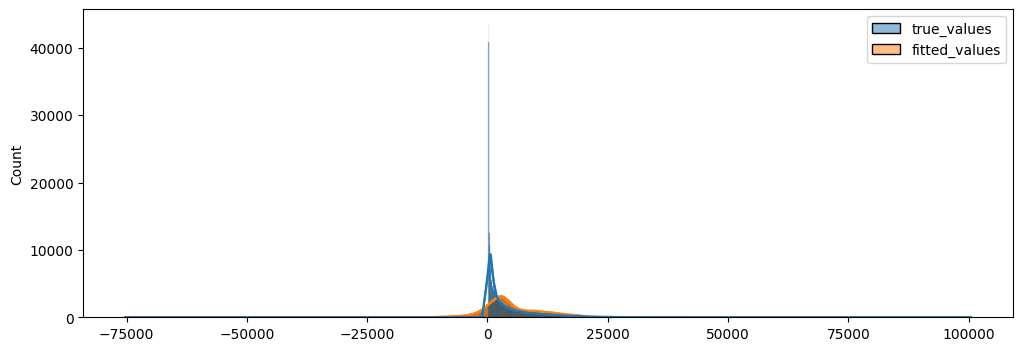

In [22]:
fig, ax = plt.subplots(figsize = (12,4))
sns.histplot(comparison_df.loc[comparison_df["true_values"] <= 20000], kde=True)
sns.histplot(comparison_df.loc[comparison_df["fitted_values"] <= 20000], kde=True)
plt.show()

O _plot_ acima sobrepõe os valores reais e os valores estimados do modelo, visando ilustrar de forma visual o desempenho do modelo. Além disso, para facilitar a visualização, realizei um filtro para mostrar apenas valores inferiores à 20k.

### Verificando a aderência dos resíduos à normalidade

Além da avaliação de métricas de erro, é importante verificar se os resíduos do modelo aderem à normalidade. Para isso, é possível utilizar o teste estátisco Shapiro-Francia, o qual valida as seguintes hipóteses:
- H0: A distribuição é aderente à normalidade;
- H1: A distribuoção não é aderente à normalidade.

Caso a distribuição dos resíduos não seja aderente a normalidade, não é possível utilizar o modelo estimado para realizar predições com base nos intervalos de confiança gerados a partir de seus parâmetros, inviabilizando seu uso de forma fidedigna.

In [23]:
test_sf = shapiro_francia(ols_model_step.resid)
test_sf = test_sf.items()
method, statistics_W, statistics_z, p = test_sf
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))

method  :  Shapiro-Francia normality test
statistics W  :  0.4522170328754786
statistics z  :  33.57316319899478
p-value  :  2.0674657486259816e-247
Statistics W=0.45222, p-value=0.000000


In [24]:
if p[1] > 0.05:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')

Rejeita-se H0 - Distribuição não aderente à normalidade


Como a distribuição dos resíduos não é aderente a normalidade, não é possível utilizar esse modelo baseando-se em seus intervalos de confiança no momento de realizar predições. No entanto, ainda é válido utilizar tal modelo como _baseline_ para fins comparativos.

## Modelo Não Linear OLS (Box-Cox Transformation)

Uma das formas de tornar uma distribuição aderente à normalidade é através da aplicação de transformações _box-cox_. A ideia é utilizar potências ou transformações logarítmicas para normalizar os dados.

Dessa forma, um modelo não linear será estimado, e seus resíduos possuem uma probabilidade maior de aderirem à distribuição normal.

Tendo tudo isso em vista, todos os métodos aplicados na estimação do modelo linear acima, também serão aplicados abaixo. A única diferença é que será necessário reverter o processo de padronização feito previamente, pois, as transformações de _box-cox_ esperam que os dados estejam em um espaço positivo.

### Revertendo a Padronização

In [25]:
bc_data = dataset.copy()
bc_data[quanti_features] = scaler.inverse_transform(dataset[quanti_features])

### Aplicando a Transformação de Box-Cox

In [26]:
bc_price, lmbda = boxcox(bc_data[TARGET])
bc_data[f"{TARGET}_TRANSFORMED"] = bc_price

In [28]:
ols_model_bc = sm.OLS.from_formula(f"{TARGET}_TRANSFORMED ~ {' + '.join(features)}",
                                bc_data.drop(columns=[TARGET])).fit()

### Aplicando o Método Stepwise

In [30]:
ols_model_bc_step = stepwise(ols_model_bc, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 QT_VENDA_BRUTO_TRANSFORMED ~ Q('FLG_DATA') + Q('QT_DEVOLUCAO') + Q('VL_RECEITA_BRUTA') + Q('VL_RECEITA_LIQUIDA') + Q('FLG_CAMPANHA_MKT_A') + Q('FLG_CAMPANHA_MKT_B') + Q('FLG_CAMPANHA_MKT_C') + Q('FLG_CAMPANHA_MKT_D') + Q('FLG_CAMPANHA_MKT_E') + Q('PCT_DESCONTO') + Q('VL_PRECO') + Q('COD_CICLO_201802') + Q('COD_CICLO_201803') + Q('COD_CICLO_201804') + Q('COD_CICLO_201805') + Q('COD_CICLO_201806') + Q('COD_CICLO_201807') + Q('COD_CICLO_201808') + Q('COD_CICLO_201809') + Q('COD_CICLO_201810') + Q('COD_CICLO_201811') + Q('COD_CICLO_201812') + Q('COD_CICLO_201813') + Q('COD_CICLO_201814') + Q('COD_CICLO_201815') + Q('COD_CICLO_201816') + Q('COD_CICLO_201817') + Q('COD_CICLO_201818') + Q('COD_CICLO_201901') + Q('COD_CICLO_201902') + Q('COD_CICLO_201903') + Q('COD_CICLO_201904') + Q('COD_CICLO_201905') + Q('COD_CICLO_201906') + Q('COD_CICLO_201907') + Q('COD_CICLO_201908') + Q('COD_CICLO_201909') + Q('COD_CICLO_201910') + Q('COD_CICLO_201911') + Q

In [31]:
ols_model_bc_step.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     QT_VENDA_BRUTO_TRANSFORMED   R-squared:                       0.448
Model:                                    OLS   Adj. R-squared:                  0.448
Method:                         Least Squares   F-statistic:                     1094.
Date:                        Tue, 13 Aug 2024   Prob (F-statistic):               0.00
Time:                                21:22:29   Log-Likelihood:            -1.2612e+05
No. Observations:                      173923   AIC:                         2.525e+05
Df Residuals:                          173793   BIC:                         2.538e+05
Df Model:                                 129                                         
Covariance Type:                    nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                4.5974      0.010    443.313      0.000       4.577       4.618
Q('FLG_DATA')                            0.0900      0.005     18.606      0.000       0.081       0.100
Q('QT_DEVOLUCAO')                        0.0002    2.3e-06    104.534      0.000       0.000       0.000
Q('VL_RECEITA_BRUTA')                -1.139e-07    1.8e-08     -6.333      0.000   -1.49e-07   -7.86e-08
Q('VL_RECEITA_LIQUIDA')               1.628e-07    1.8e-08      9.034      0.000    1.27e-07    1.98e-07
Q('FLG_CAMPANHA_MKT_A')                  0.0456      0.010      4.776      0.000       0.027       0.064
Q('FLG_CAMPANHA_MKT_B')                  0.3968      0.006     65.588      0.000       0.385       0.409
Q('FLG_CAMPANHA_MKT_C')                  0.1163      0.007     17.491      0.000       0.103       0.129
Q('FLG_CAMPANHA_MKT_D')                  0.2651      0.006     43.292      0.000       0.253       0.277
Q('FLG_CAMPANHA_MKT_E')              -5.947e-11    6.8e-12     -8.741      0.000   -7.28e-11   -4.61e-11
Q('PCT_DESCONTO')                        0.0088      0.000     32.412      0.000       0.008       0.009
Q('VL_PRECO')                         2.093e-05   8.33e-06      2.512      0.012     4.6e-06    3.73e-05
Q('COD_CICLO_201802')                   -0.0859      0.010     -9.006      0.000      -0.105      -0.067
Q('COD_CICLO_201803')                    0.0214      0.010      2.218      0.027       0.002       0.040
Q('COD_CICLO_201804')                    0.1025      0.010     10.695      0.000       0.084       0.121
Q('COD_CICLO_201805')                    0.0203      0.010      2.088      0.037       0.001       0.039
Q('COD_CICLO_201806')                    0.0628      0.010      6.566      0.000       0.044       0.082
Q('COD_CICLO_201807')                    0.0804      0.010      8.161      0.000       0.061       0.100
Q('COD_CICLO_201808')                    0.0240      0.010      2.508      0.012       0.005       0.043
Q('COD_CICLO_201809')                   -0.0244      0.010     -2.485      0.013      -0.044      -0.005
Q('COD_CICLO_201810')                    0.0500      0.010      5.250      0.000       0.031       0.069
Q('COD_CICLO_201811')                    0.0342      0.009      3.657      0.000       0.016       0.053
Q('COD_CICLO_201813')                   -0.0424      0.009     -4.498      0.000      -0.061      -0.024
Q('COD_CICLO_201814')                    0.0810      0.010      8.509      0.000       0.062       0.100
Q('COD_CICLO_201815')                    0.0388      0.010      4.062      0.000       0.020       0.057
Q('COD_CICLO_201816')                    0.0771      0.

Para comparar o modelo acima com o modelo estimado previamente (linear), será preciso analisar a métrica Adjusted R². Isso é necessário, pois os parâmetros utilizados no modelo acima podem ser diferentes dos parâmetros utilizados no modelo inicial devido à aplicação do método Stepwise.

Tendo isso em vista, é possível observar que, infelizmente o Adjusted R² do modelo acima não superou o modelo inicial. Agora, as variáveis utilizadas explicam apenas 44.8% da variância da variável TARGET.

### Valores Reais x Valores Estimados

In [32]:
comparison_df = pd.DataFrame(data=[bc_data[f"{TARGET}_TRANSFORMED"].values, ols_model_bc_step.fittedvalues.values]).T
comparison_df.columns = ["true_values", "fitted_values"]

In [33]:
comparison_df["fitted_values"] = inv_boxcox(comparison_df["fitted_values"].values, lmbda)

In [34]:
comparison_df.dropna(inplace=True)

### Métricas de Erro

In [36]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
print(f"MSE: {mse(comparison_df['true_values'].values, comparison_df['fitted_values'])}")
print(f"MAE: {mae(comparison_df['true_values'].values, comparison_df['fitted_values'])}")

MSE: 2.8494438424979444e+50
MAE: 4.052934987959477e+22


Assim como o Adjusted R² deste modelo não superou o modelo inicial, as métricas de erro também se mostraram piores. Sendo assim, até o momento, o modelo inicial é métricamente superior ao modelo não linear em termos de erro e explicação da variável dependente.

### Verificando a aderência dos resíduos à normalidade

Agora, após a aplicação de uma transformação _box-cox_, é importante verificar se os resíduos finalmente possuem aderência à normalidade.

In [39]:
test_sf = shapiro_francia(ols_model_bc_step.resid)
test_sf = test_sf.items()
method, statistics_W, statistics_z, p = test_sf
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))

method  :  Shapiro-Francia normality test
statistics W  :  0.9786531745257746
statistics z  :  23.434560915905827
p-value  :  9.498136021241005e-122
Statistics W=0.97865, p-value=0.000000


In [40]:
if p[1] > 0.05:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')

Rejeita-se H0 - Distribuição não aderente à normalidade


Infelizmente os resíduos do modelo não linear também não são aderentes à normalidade, indicando que as estimativas desse modelo não são fidedignas de acordo com seus intervalos de confiança.

# Próximos Passos
Como ponto inicial, minha ideia é utilizar um regressor baseado em árvores decisão, como por exemplo o XGBoost para explicar o comportamento da variável dependente.

Além disso, será possível realizar comparações métricas entre o modelo que será desenvolvido e os modelos estimados nessa exploração.